In [0]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import keras
import string as st
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from google.colab import files
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt


***Run the code in google colab.***

# ***Neural Machine Translation from German to english using encoder decoder sequence model.***


# ***Dataset is restricted to 60000 records apporx. for this execution (total dataset is of 174481 records).***

I have generated the output in the csv file 'predicted.csv' which will be visible in the left pane on refreshing.

In [10]:
# convert data into dataframe  
data = pd.read_csv('deu.txt', delimiter='\t', names=['English', 'German'], usecols=[0,1])
dataCopy=data
data.head()

,English,German
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Wow!,Potzdonner!
4,Wow!,Donnerwetter!


In [0]:
data.shape
# restrict dataset to 35000 records
dataLimit = np.random.rand(len(dataCopy)) <= 0.3
limitDataset=dataCopy[dataLimit]

In [12]:
limitDataset.shape

(61533, 2)

In [13]:
#keras based tokenizer is used to map words to integer
tokenizerEn=Tokenizer()
tokenizerFr=Tokenizer()

tokenizerEn.fit_on_texts(limitDataset['English'].to_numpy())
vocabSizeEn = len(tokenizerEn.word_index) + 1

tokenizerFr.fit_on_texts(limitDataset['German'].to_numpy())
vocabSizeFr = len(tokenizerFr.word_index) + 1

print('Vocabulary Size: English ', vocabSizeEn, "German ", vocabSizeFr)

Vocabulary Size: English  10745 German  19767


In [14]:
#Data preprocessing to clean the data and get the maximum sized length of sentences from both languages
maxLenEn = 0
maxLenFr = 0
for index, row in limitDataset.iterrows():
    row['English']=row['English'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['English'].split())>maxLenEn:
        maxLenEn=len(row['English'].split())
    row['German']=row['German'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['German'].split())>maxLenFr:
        maxLenFr=len(row['German'].split())  
print("Maximum sized length : English ",maxLenEn,"German ", maxLenFr )

Maximum sized length : English  38 German  44


In [15]:
# we will split the data to keep 80:20 ratio for training and test data
splitData = np.random.rand(len(limitDataset)) <= 0.8
trainData = limitDataset[splitData]
testData = limitDataset[~splitData]
#check the data count in training set and test set
print("Training Data: ",trainData.shape," Test data: ",testData.shape)
# Data in to numpy array conversion
trainDataNP=trainData.to_numpy()
testDataNP=testData.to_numpy()

Training Data:  (49153, 2)  Test data:  (12380, 2)


**Data encoding is done i.e. converting text to ids and add padding to make all sequences of same length. **

In [0]:
def dataEncoder(allData, lanTokenizer, length):
    encodedData = lanTokenizer.texts_to_sequences(allData)
    paddedData = pad_sequences(encodedData, maxlen=length, padding='post')
    return paddedData

trainFr = dataEncoder(trainDataNP[:, 1],tokenizerFr,maxLenFr)
trainEn = dataEncoder(trainDataNP[:, 0],tokenizerEn,maxLenEn)
testFr = dataEncoder(testDataNP[:, 1],tokenizerFr,maxLenFr)
testEn = dataEncoder(testDataNP[:, 0],tokenizerEn,maxLenEn)

In [17]:
print(trainFr.shape, testFr.shape)

(49153, 44) (12380, 44)


In [18]:
#Sequence model
def sequenceModel(vocabFr, vocabEn, maxFr, maxEn, units):
    seqModel = Sequential()
    seqModel.add(Embedding(vocabFr, units, input_length=maxFr, mask_zero=True))
    seqModel.add(LSTM(units))
    seqModel.add(RepeatVector(maxEn))
    seqModel.add(LSTM(units, return_sequences=True))
    seqModel.add(Dense(vocabEn, activation='softmax'))
    return seqModel

seqModel = sequenceModel(vocabSizeFr, vocabSizeEn, maxLenFr, maxLenEn, 256)
rmsOptimizer = optimizers.RMSprop(lr=0.01)
seqModel.compile(optimizer=rmsOptimizer, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [19]:
modelPrediction = seqModel.fit(trainFr, trainEn.reshape(trainEn.shape[0], trainEn.shape[1], 1),epochs=15, batch_size=256, validation_split = 0.2, verbose=1)




Train on 39322 samples, validate on 9831 samples
Epoch 1/15





39322/39322 [==============================] - 215s 5ms/step - loss: 1.1602 - val_loss: 2.1024
Epoch 2/15
39322/39322 [==============================] - 211s 5ms/step - loss: 0.7410 - val_loss: 1.7944
Epoch 3/15
39322/39322 [==============================] - 213s 5ms/step - loss: 0.6024 - val_loss: 1.7540
Epoch 4/15
39322/39322 [==============================] - 211s 5ms/step - loss: 0.5083 - val_loss: 1.6761
Epoch 5/15
39322/39322 [==============================] - 211s 5ms/step - loss: 0.4386 - val_loss: 1.7224
Epoch 6/15
39322/39322 [==============================] - 211s 5ms/step - loss: 0.3843 - val_loss: 1.8007
Epoch 7/15
39322/39322 [==============================] - 211s 5ms/step - loss: 0.3404 - val_loss: 1.8116
Epoch 8/15
39322/39322 [==============================] - 212s 5ms/step - loss: 0.3046 - val_loss: 1.8248
Epoch 9/15
39322/39322 [==============================] - 213s 5ms/step - loss: 0.2759 - val_lo

In [0]:
#Get predictions for text data 
testPrediction = seqModel.predict_classes(testFr.reshape((testFr.shape[0],testFr.shape[1])))

In [0]:
## data decoder Convert mapped words in to normal words
def wordConversion(word_index, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == word_index:
            return word
    return None
    
def dataDecoder(prediction):
    textPredicted=list()
    for sentence in prediction:
        sentenceConverted = list()
        for word_index in range(len(sentence)):
            word = wordConversion(sentence[word_index], tokenizerEn)
            if word_index > 0:
                if (word == wordConversion(sentence[word_index-1], tokenizerEn)) or (word == None):
                    sentenceConverted.append('')
                else:
                    sentenceConverted.append(word)

            else:
                if(word == None):
                    sentenceConverted.append('')
                else:
                    sentenceConverted.append(word)            

        textPredicted.append(' '.join(sentenceConverted))
        
    return textPredicted

In [0]:
#calling data decoder for the predictions
predictedText = dataDecoder(testPrediction)
predictedDataframe = pd.DataFrame({'German text': testData['German'],' Expected text' : testData['English'], 'Predicted text' : predictedText})

# ***Data after conversion from German to english i.e. both the expected and predicted english text***

In [23]:

predictedDataframe.head(10)

,German text,Expected text,Predicted text
20,iss auf,eat up,stay up
23,kapiert,got it,get a
29,drück mich,hug me,keep me
45,ich bin 19,im 19,a
69,sei fair,be fair,be fair
77,zieh leine,beat it,just lost
84,mach ’ne fliege,beat it,lets go
90,komm herein,come in,come on in
100,geh raus,get out,get were
115,schwirr ab,go away,go away


# ***Using corpus bleu function to calculate the Bleu score for data***

In [24]:
print('BLEU score using corpus bleu function:',corpus_bleu(testDataNP[:,0], predictedText))

BLEU score using corpus bleu function: 0.6533581233297084


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## ***Ploting training and validation losses***



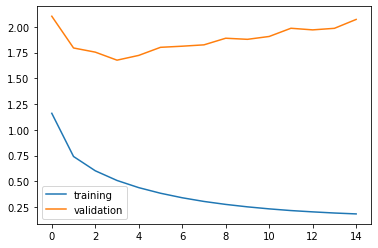

In [25]:
plt.plot(modelPrediction.history['loss'])
plt.plot(modelPrediction.history['val_loss'])
plt.legend(['training','validation'])
plt.show()